In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [ ]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

ganancia_acierto = 273000
costo_estimulo = 7000

semillas = [779, 296, 720, 433, 405, 610, 902, 910, 535, 734, 325, 469, 841, 399, 929, 481, 521, 709, 444, 596]

In [3]:
df_cpe_file = 'competencia_02_inflacion_adj_cpe.parquet'
df_ipc_file = 'competencia_02_inflacion_adj_ipc.parquet'
df_sin_adj_file = 'competencia_02.parquet'

### Test de ajuste por CPE

In [4]:
data = pl.scan_parquet(dataset_path + df_cpe_file).filter(pl.col("foto_mes") == 202106).collect()

In [5]:
data = data.to_pandas()

In [6]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [7]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [8]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [9]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

In [10]:
version = 'cpe'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_cpe' in modelo]

In [11]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s296.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s325.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s399.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s405.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s433.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s444.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s469.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s481.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s521.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s535.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s596.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s610.txt',
 'C:

In [12]:
ganancia_acumulada_cpe = []
ganancia_maxima_cpe = []
numero_envios_cpe = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada_cpe.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima_cpe.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios_cpe.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio_cpe = np.mean(ganancia_acumulada_cpe, axis=0)
ganancia_maxima_promedio_cpe = ganancia_acumulada_promedio_cpe.max()
numero_envios_promedio_cpe = np.where(ganancia_acumulada_promedio_cpe == ganancia_maxima_promedio_cpe)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio_cpe/1000000} millones y se alcanza con {numero_envios_promedio_cpe} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima_cpe)/1000000} millones y de {np.std(numero_envios_cpe)} envios')

En promedio la ganancia obtenida es 92.792 millones y se alcanza con 10741 envios
El desvio estandar de la ganancia maxima es de 1.5180769776266287 millones y de 1093.7730066151753 envios


In [15]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima_cpe,
    'Numero de Envios': numero_envios_cpe,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,92106000,10321,779
1,94885000,13484,296
2,93653000,12580,720
3,94682000,12513,433
4,94808000,11895,405
5,92645000,11844,610
6,93345000,10704,902
7,96467000,11578,910
8,94094000,13957,535
9,92624000,10127,734


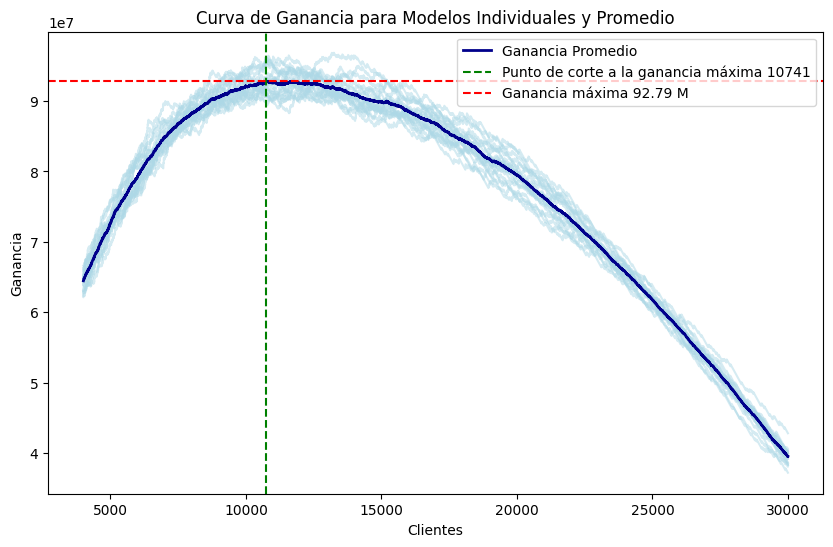

In [16]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_cpe:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio_cpe[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio_cpe[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio_cpe,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio_cpe}'
)

plt.axhline(
    y=ganancia_maxima_promedio_cpe,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio_cpe/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Test de ajuste por IPC

In [17]:
data = pl.scan_parquet(dataset_path + df_ipc_file).filter(pl.col("foto_mes") == 202106).collect()

In [18]:
data = data.to_pandas()

In [19]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [20]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [21]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [22]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [23]:
version = 'ipc'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_ipc' in modelo]

In [24]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s296.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s325.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s399.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s405.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s433.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s444.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s469.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s481.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s521.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s535.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s596.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s610.txt',
 'C:

In [25]:
ganancia_acumulada_ipc = []
ganancia_maxima_ipc = []
numero_envios_ipc = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada_ipc.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima_ipc.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios_ipc.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio_ipc = np.mean(ganancia_acumulada_ipc, axis=0)
ganancia_maxima_promedio_ipc = ganancia_acumulada_promedio_ipc.max()
numero_envios_promedio_ipc = np.where(ganancia_acumulada_promedio_ipc == ganancia_maxima_promedio_ipc)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio_ipc/1000000} millones y se alcanza con {numero_envios_promedio_ipc} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima_ipc)/1000000} millones y de {np.std(numero_envios_ipc)} envios')

En promedio la ganancia obtenida es 93.527 millones y se alcanza con 11204 envios
El desvio estandar de la ganancia maxima es de 1.268458090557193 millones y de 1316.9791370784885 envios


In [26]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima_ipc,
    'Numero de Envios': numero_envios_ipc,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,95473000,11240,779
1,96089000,11712,296
2,94661000,12996,720
3,95018000,9065,433
4,94885000,12604,405
5,93800000,14679,610
6,95256000,13911,902
7,93905000,11064,910
8,96348000,11035,535
9,93590000,13069,734


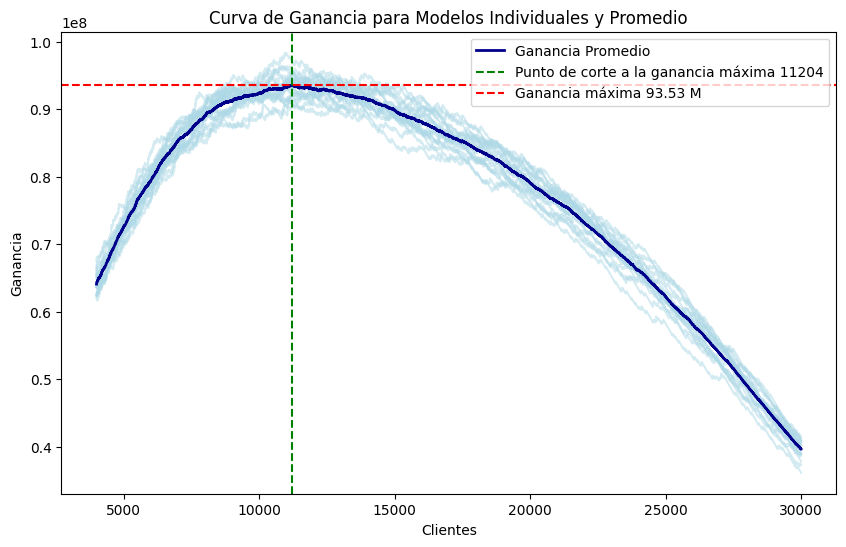

In [27]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_ipc:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio_ipc[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio_ipc[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio_ipc,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio_ipc}'
)

plt.axhline(
    y=ganancia_maxima_promedio_ipc,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio_ipc/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Test sin ajustar por ipc/cpe

In [28]:
data = pl.scan_parquet(dataset_path + df_sin_adj_file).filter(pl.col("foto_mes") == 202106).collect()

In [29]:
data = data.to_pandas()

In [30]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [31]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [32]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [33]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [34]:
version = 'sin_adj'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_sin_adj' in modelo]

In [35]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s296.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s325.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s399.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s405.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s433.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s444.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s469.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s481.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s521.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s535.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s596.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experim

In [36]:
ganancia_acumulada_sin_adj = []
ganancia_maxima_sin_adj = []
numero_envios_sin_adj = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada_sin_adj.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima_sin_adj.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios_sin_adj.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio_sin_adj = np.mean(ganancia_acumulada_sin_adj, axis=0)
ganancia_maxima_promedio_sin_adj = ganancia_acumulada_promedio_sin_adj.max()
numero_envios_promedio_sin_adj = np.where(ganancia_acumulada_promedio_sin_adj == ganancia_maxima_promedio_sin_adj)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio_sin_adj/1000000} millones y se alcanza con {numero_envios_promedio_sin_adj} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima_sin_adj)/1000000} millones y de {np.std(numero_envios_sin_adj)} envios')

En promedio la ganancia obtenida es 93.17 millones y se alcanza con 10795 envios
El desvio estandar de la ganancia maxima es de 1.5690963354746579 millones y de 1053.4566863426328 envios


In [37]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima_sin_adj,
    'Numero de Envios': numero_envios_sin_adj,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,92911000,10166,779
1,91126000,10821,296
2,95375000,9334,720
3,95438000,10165,433
4,92533000,11380,405
5,95179000,10842,610
6,94549000,11252,902
7,95592000,11503,910
8,92554000,12417,535
9,96040000,10839,734


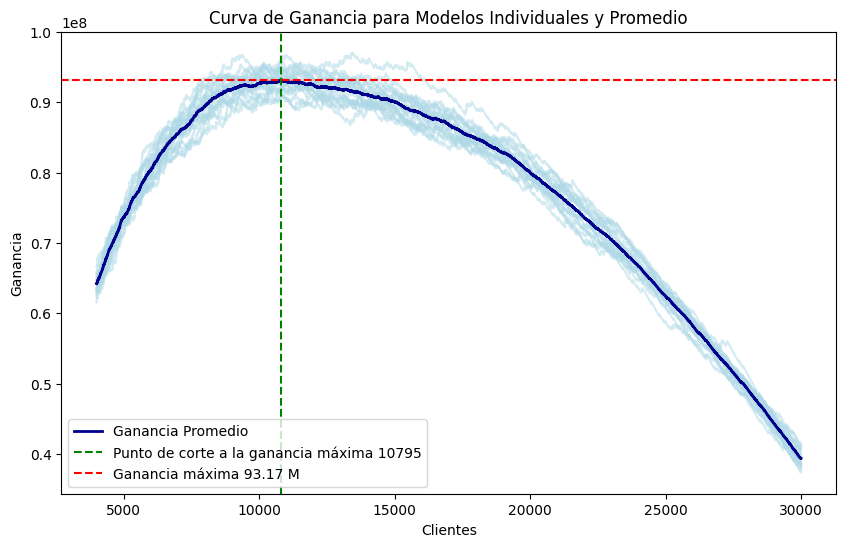

In [38]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_sin_adj:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio_sin_adj[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio_sin_adj[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio_sin_adj,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio_sin_adj}'
)

plt.axhline(
    y=ganancia_maxima_promedio_sin_adj,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio_sin_adj/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

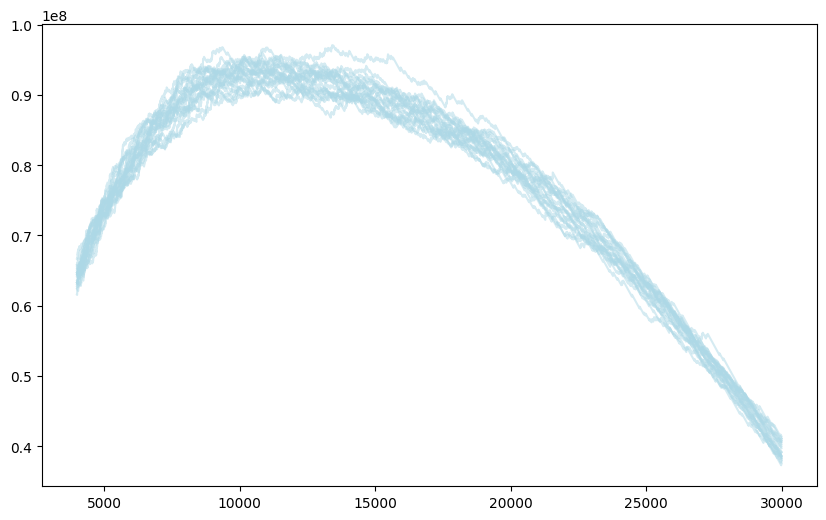

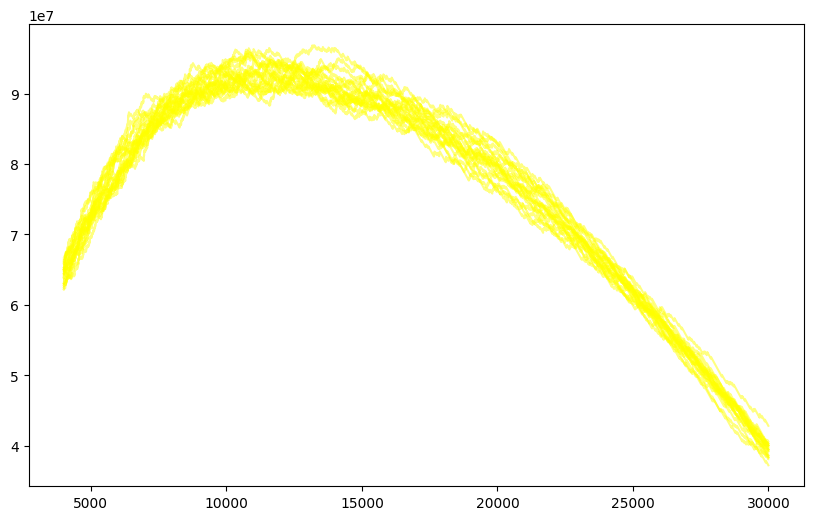

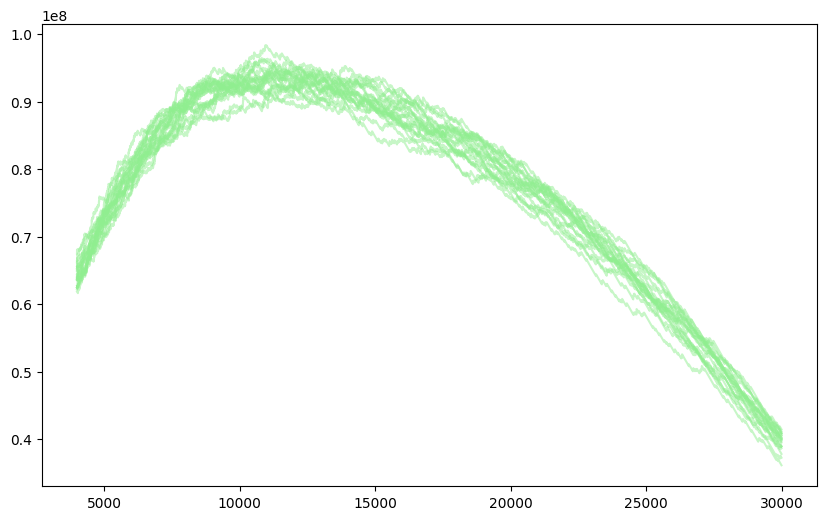

In [39]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_sin_adj:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )
    
plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_cpe:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='yellow',
        alpha=0.5
    )
    
plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_ipc:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightgreen',
        alpha=0.5
    )

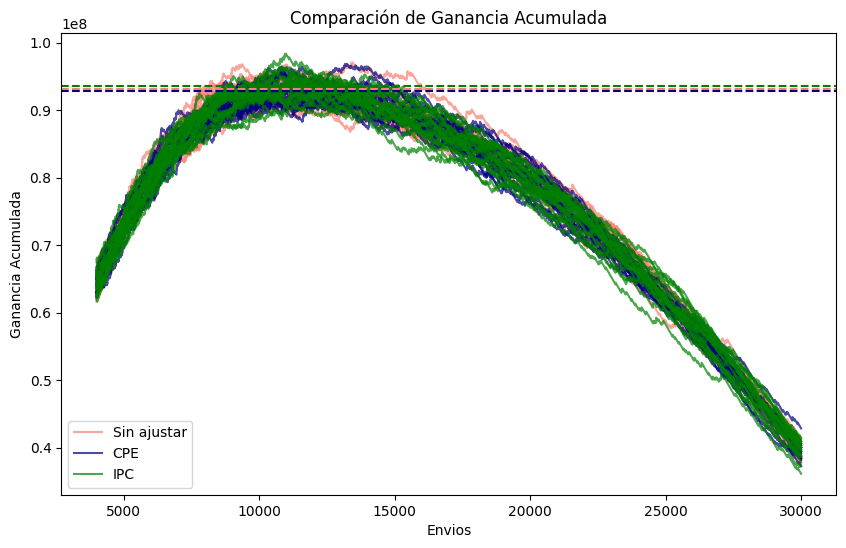

In [40]:
plt.figure(figsize=(10, 6))

# Plotting 'Sin ajustar'
for ganancia_cum in ganancia_acumulada_sin_adj:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='salmon',
        alpha=0.7,
        label='Sin ajustar' if ganancia_cum is ganancia_acumulada_sin_adj[0] else ""  # Add label only once
    )

# Plotting 'CPE'
for ganancia_cum in ganancia_acumulada_cpe:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='navy',
        alpha=0.7,
        label='CPE' if ganancia_cum is ganancia_acumulada_cpe[0] else ""  # Add label only once
    )

# Plotting 'IPC'
for ganancia_cum in ganancia_acumulada_ipc:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='green',
        alpha=0.7,
        label='IPC' if ganancia_cum is ganancia_acumulada_ipc[0] else ""  # Add label only once
    )

# Adding lines with labels
plt.axhline(
    y=ganancia_maxima_promedio_sin_adj,
    color='salmon',
    linestyle='--',
    # label=f'Ganancia máxima {ganancia_maxima_promedio_sin_adj/1000000:.2f} M'
)

plt.axhline(
    y=ganancia_maxima_promedio_cpe,
    color='navy',
    linestyle='--'
)

plt.axhline(
    y=ganancia_maxima_promedio_ipc,
    color='green',
    linestyle='--',
)

# Adding legend and labels
plt.legend()
plt.xlabel("Envios")
plt.ylabel("Ganancia Acumulada")
plt.title("Comparación de Ganancia Acumulada")
plt.show()

In [ ]:
df_pred = pd.DataFrame({'Ganancia': [result[1] for result in results_base], 'Modelo': 'Base'})
df_pred2 = pd.DataFrame({'Ganancia': [result[1] for result in results_ale], 'Modelo': 'Ale'})
df_combined = pd.concat([df_pred, df_pred2])

g = sns.FacetGrid(df_combined, row="Modelo", aspect=2)
g.map(sns.histplot, "Ganancia", kde=True)
plt.show()